In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#<font color='orange'>Basics</font>

In [32]:
#@title **Location** of the dataset
path =  "../data/HomeCredit/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold


In [34]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [36]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri

from submodules.topsis_python import topsis as top
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
import seaborn as sns

[x] add kfold

[x] add topsis/ahp multicriterio

[x] add criterio de parada

[-] pip freeze

#Read Dataset

In [37]:
#@title Read dataset
df_o = pd.read_csv(path+'application_train.csv')    #HomeCredit training dataset

In [38]:
#@title Create develoment train and test
df_train, df_test = tr.create_train_test(df_o, seed=43)

In [39]:
#@title Set seed
new_seed = False #@param {type:"boolean"}

if new_seed:
    seed_number = secrets.randbelow(1_000) #to name the results files

    while seed_number <100:
        seed_number = secrets.randbelow(1_000)
else:
    seed_number = 154440

main_seed = seed_number

print(seed_number)

154440


#Params

In [40]:
params_dict = ri.params_dict

In [41]:
params_dict['LightGBM_2'] = {'boosting_type': 'gbdt', 'class_weight': None,
              'colsample_bytree': 0.22534977954592625, 'importance_type': 'split',
              'learning_rate': 0.052227873762946964, 'max_depth': 5,
              'min_child_samples': 26, 'min_child_weight': 0.001,
              'min_split_gain': 0.0, 'n_estimators': 159, 'n_jobs': -1,
              'num_leaves': 12, 'objective': None, 'random_state': seed_number,
              'reg_alpha': 0.7438345471808012, 'reg_lambda': 0.46164693905368515,
                'verbose': -1, 'subsample': 0.8896599304061413,
              'subsample_for_bin': 200000, 'subsample_freq': 0,
              'is_unbalance': True}

In [42]:
# seed_number = 3883890
size = 1000
p_value = 0.07
contamination_threshold = 0.12

#<font color='orange'>Helper Functions</font>


#<font color='red'>Definition of Train and Test Val, and Unl</font>

In [43]:
df_o = df_o.sample(random_state=seed_number, n=size*20)

In [44]:
N_splits=5
kf = KFold(n_splits=N_splits, random_state=main_seed, shuffle=True)   #80-20 split for train-test
hist_dict = {}
data_dict = {}
run = False or True

for fold_number, (train_index, test_index) in enumerate(kf.split(df_o)):
    #diferent seed for each iteration
    seed_number = main_seed+fold_number

    df_train = df_o.iloc[train_index]
    df_test = df_o.iloc[test_index]
    
    val_split = int(df_train.shape[0] * 0.2)  #80-20 split for train-validation
    df_val = df_train.iloc[:val_split]
    df_train = df_train.iloc[val_split:]

    df_train, policy_model = ri.fit_policy(df_train)

    X_train, X_test, X_val = df_train, df_test, df_val
    y_train, y_test, y_val = df_train["TARGET"], df_test["TARGET"], df_val["TARGET"]

    X_train_acp, X_train_rej, y_train_acp, y_train_rej = ri.accept_reject_split(X_train, y_train, policy_clf=policy_model, threshold=0.3)
    X_test_acp, X_test_rej, y_test_acp, y_test_rej = ri.accept_reject_split(X_test, y_test, policy_clf=policy_model, threshold=0.3)
    X_val_acp, X_val_rej, y_val_acp, y_val_rej = ri.accept_reject_split(X_val, y_val, policy_clf=policy_model, threshold=0.3)
    
    data_dict[fold_number] = [X_train_acp, X_train_rej, y_train_acp, y_train_rej,
                               X_test_acp, X_test_rej, y_test_acp,
                               X_val_acp, X_val_rej, y_val_acp]
    # dex.get_shapes(X_train_acp, X_train_rej, X_test_acp, X_test_rej, X_val_acp, X_val_rej)

    # metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej)
    models_dict = {}

    filepath_models = Path(os.path.join(ri_datasets_path,f'HC/Models/RI/models-{seed_number}.joblib'))
    if filepath_models.exists():
        models_dict = joblib.load(filepath_models)
        print(f'Models loaded with shape: {len(models_dict.keys())}')
    else:
        benchmark = tr.create_pipeline(X_train_acp, y_train_acp,
                                    LGBMClassifier(**params_dict['LightGBM_2']))
        benchmark.fit(X_train_acp, y_train_acp)

        
        models_dict['BM'] = benchmark

        models_dict.update(
            ri.augmentation_with_soft_cutoff(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
        models_dict.update(
            ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='up', seed = seed_number))
        models_dict.update(
            ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='down', seed = seed_number))
        models_dict.update(
            ri.fuzzy_augmentation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
        models_dict.update(
            ri.extrapolation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
        models_dict.update(
            ri.parcelling(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
        models_dict.update(
            ri.label_spreading(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
        
        filepath_models.parent.mkdir(parents=True, exist_ok=True)
        joblib.dump(models_dict, filepath_models)

    if run:
        filepath_ex = Path(os.path.join(ri_datasets_path,f'HC/Models/TN-{seed_number}/{size}-{p_value}-{contamination_threshold}.joblib'))
        datapath_ex = Path(os.path.join(ri_datasets_path,f'HC/Data/TN-/{seed_number}/{size}-{p_value}-{contamination_threshold}.parquet'))
        if filepath_ex.exists() & False:
            models_ex = joblib.load(filepath_ex)
            print(f'TN loaded with shape: {len(models_ex.keys())}')
        else:
            print(f'TN fitting started with seed {seed_number}')
            TNmodels, TNdata = ri.trusted_non_outliers(X_train_acp, y_train_acp, X_train_rej,
                                    X_val_acp, y_val_acp, iterations=5,p = 0.07, output=-1,return_all=True,
                                    save_log=False, seed=seed_number, technique='extrapolation')
            print(f'TN fitted')
            filepath_ex.parent.mkdir(parents=True, exist_ok=True)
            datapath_ex.parent.mkdir(parents=True, exist_ok=True)
            joblib.dump(TNmodels, filepath_ex)

            #------------------------------------
            print(f'starting compactation of TN data')
            train_list = [pd.DataFrame({**item, 'group': i}) for i, item in enumerate(TNdata['X'])]
            last_df = TNdata['unl'][-1].copy()
            last_df.loc[:, 'group'] = -1

            df = pd.concat(train_list, axis=0, ignore_index=False)
            df = pd.concat([df, last_df])

            min_values = df.group.groupby(level=0).min()
            last_value = TNdata['y'][-1]

            result_df = pd.DataFrame({
                'first_it': min_values,
                'label': last_value
            }, index=min_values.index)
            result_df = result_df.sort_values(by=['first_it'], ascending=True)
            result_df.fillna(-1, inplace=True)
            result_df = result_df.astype(int)

            result_df.to_parquet(datapath_ex)
            print(f'data saved to {datapath_ex}')
            #------------------------------------
            models_ex = TNmodels
          
    hist_dict[fold_number] = models_dict
        # metrics_dict[fold_number] = ri.get_metrics_RI(models_dict, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej)
    print(fold_number)
    break
    # break

ok


Models loaded with shape: 8
TN fitting started with seed 154440
TN fitted
starting compactation of TN data
data saved to ../data/riData/HC/Data/TN-/154440/1000-0.07-0.12.parquet
0


In [45]:
data_ex = pd.read_parquet(datapath_ex)
data_ex.head()

,first_it,label
index,,
78578,-1,-1
78601,-1,-1
78606,-1,-1
78644,-1,-1
78751,-1,-1


In [46]:
iteration = 5

ki = y_train_rej.combine_first(y_train_acp).reindex(data_ex.index).astype('int32')
data_ex.loc[:,'gt'] = ki

train_i = data_ex.loc[(data_ex.first_it <= iteration) & (data_ex.first_it >=0) ,:]
rej_left = data_ex.loc[(data_ex.first_it==-1) ,:]
first_added = X_train_rej.loc[X_train_rej.index.intersection(train_i.index),:]

not_added = data_ex.loc[(data_ex.first_it==-1) ,:]
df_left = X_train_rej.loc[X_train_rej.index.intersection(not_added.index),:]
df_left = pd.concat([df_left, rej_left], axis=1)

df_i = pd.concat([X_train_acp, first_added], axis=0)
df_i = pd.concat([df_i, train_i], axis=1)

assert df_i.shape[0] == (X_train_acp.shape[0] + first_added.shape[0])

In [47]:
data_ex

,first_it,label,gt
index,,,
78578,-1,-1,1
78601,-1,-1,0
78606,-1,-1,0
78644,-1,-1,1
78751,-1,-1,0
...,...,...,...
990,5,0,0
307447,5,0,0
306200,5,1,0


In [48]:
df_i

,AMT_CREDIT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_BIRTH,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,REG_CITY_NOT_WORK_CITY,AMT_GOODS_PRICE,FLAG_OWN_CAR,NAME_EDUCATION_TYPE,NAME_CONTRACT_TYPE,first_it,label,gt
72700,1575000.0,NaN,0.496782,0.466864,0.022800,-1052,-17606,292500.0,0,2.0,0,1575000.0,Y,Secondary / secondary special,Cash loans,0,0,0
303025,47970.0,NaN,0.670648,NaN,0.026392,365243,-22759,54000.0,0,2.0,0,45000.0,N,Secondary / secondary special,Cash loans,0,0,0
281935,755190.0,NaN,0.285898,0.053114,0.008866,-4053,-19541,90000.0,0,1.0,0,675000.0,N,Secondary / secondary special,Cash loans,0,0,0
179516,900000.0,NaN,0.796409,0.605836,0.032561,-7835,-15437,292500.0,1,3.0,0,900000.0,N,Secondary / secondary special,Cash loans,0,0,0
35274,481495.5,NaN,0.674482,0.488455,0.004960,-6962,-15434,211500.0,0,2.0,0,454500.0,N,Higher education,Cash loans,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,1125000.0,NaN,0.615401,0.432962,0.020713,-4924,-18138,270000.0,1,3.0,0,1125000.0,N,Secondary / secondary special,Cash loans,4,0,0
200718,355536.0,0.749134,0.655728,NaN,0.003069,365243,-21301,151785.0,0,2.0,0,270000.0,N,Higher education,Cash loans,1,0,0
252780,754740.0,NaN,0.623073,0.291097,0.018029,-8471,-18525,60750.0,0,2.0,0,630000.0,N,Secondary / secondary special,Cash loans,5,0,1
146374,755190.0,NaN,0.675441,0.581484,0.003541,-2288,-12600,247500.0,0,2.0,0,675000.0,N,Secondary / secondary special,Cash loans,4,0,0


In [49]:
models_dict = joblib.load(filepath_models)

In [50]:
df_i.head()

,AMT_CREDIT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_BIRTH,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,REG_CITY_NOT_WORK_CITY,AMT_GOODS_PRICE,FLAG_OWN_CAR,NAME_EDUCATION_TYPE,NAME_CONTRACT_TYPE,first_it,label,gt
72700,1575000.0,NaN,0.496782,0.466864,0.022800,-1052,-17606,292500.0,0,2.0,0,1575000.0,Y,Secondary / secondary special,Cash loans,0,0,0
303025,47970.0,NaN,0.670648,NaN,0.026392,365243,-22759,54000.0,0,2.0,0,45000.0,N,Secondary / secondary special,Cash loans,0,0,0
281935,755190.0,NaN,0.285898,0.053114,0.008866,-4053,-19541,90000.0,0,1.0,0,675000.0,N,Secondary / secondary special,Cash loans,0,0,0
179516,900000.0,NaN,0.796409,0.605836,0.032561,-7835,-15437,292500.0,1,3.0,0,900000.0,N,Secondary / secondary special,Cash loans,0,0,0
35274,481495.5,NaN,0.674482,0.488455,0.004960,-6962,-15434,211500.0,0,2.0,0,454500.0,N,Higher education,Cash loans,0,0,0


In [51]:
df_all = pd.concat([df_i, df_left], axis=0)
df_all.head()

,AMT_CREDIT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_BIRTH,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,REG_CITY_NOT_WORK_CITY,AMT_GOODS_PRICE,FLAG_OWN_CAR,NAME_EDUCATION_TYPE,NAME_CONTRACT_TYPE,first_it,label,gt
72700,1575000.0,NaN,0.496782,0.466864,0.022800,-1052,-17606,292500.0,0,2.0,0,1575000.0,Y,Secondary / secondary special,Cash loans,0,0,0
303025,47970.0,NaN,0.670648,NaN,0.026392,365243,-22759,54000.0,0,2.0,0,45000.0,N,Secondary / secondary special,Cash loans,0,0,0
281935,755190.0,NaN,0.285898,0.053114,0.008866,-4053,-19541,90000.0,0,1.0,0,675000.0,N,Secondary / secondary special,Cash loans,0,0,0
179516,900000.0,NaN,0.796409,0.605836,0.032561,-7835,-15437,292500.0,1,3.0,0,900000.0,N,Secondary / secondary special,Cash loans,0,0,0
35274,481495.5,NaN,0.674482,0.488455,0.004960,-6962,-15434,211500.0,0,2.0,0,454500.0,N,Higher education,Cash loans,0,0,0


In [52]:
df_all.first_it.value_counts()

first_it
 0    2626
-1    2614
 4    1000
 1    1000
 5    1000
 2    1000
 3    1000
Name: count, dtype: int64

In [53]:
X = df_all.loc[:, ~df_all.columns.isin(['first_it', 'label','gt'])]
X_scaled_df = models_dict['BM'][:-2].transform(X)
X_scaled_df.head()

,AMT_CREDIT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_BIRTH,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,REG_CITY_NOT_WORK_CITY,AMT_GOODS_PRICE,FLAG_OWN_CAR,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE
72700,2.278816,0.0,-0.265282,-2.888707e-01,-0.070736,-0.626006,-0.145733,1.105609,-0.539483,-0.105504,-0.428497,2.649935,1,0,0.073082
303025,-1.358849,0.0,0.667736,-6.410466e-16,0.153276,1.573403,-1.278660,-1.170305,-0.539483,-0.105504,-0.428497,-1.333152,0,0,0.073082
281935,0.325878,0.0,-1.396947,-2.677876e+00,-0.939717,-0.644025,-0.571158,-0.826771,-0.539483,-1.227931,-0.428497,0.306943,0,0,0.073082
179516,0.670842,0.0,1.342601,5.135598e-01,0.538000,-0.666734,0.331139,1.105609,0.911431,1.016923,-0.428497,0.892691,0,0,0.073082
35274,-0.326112,0.0,0.688306,-1.642025e-01,-1.183311,-0.661492,0.331798,0.332657,-0.539483,-0.105504,-0.428497,-0.267090,0,0,0.042657


In [54]:
df_scaled = pd.concat([X_scaled_df, df_all.loc[:, ['first_it', 'label', 'gt']]], axis=1)
df_scaled.head()

,AMT_CREDIT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_BIRTH,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,REG_CITY_NOT_WORK_CITY,AMT_GOODS_PRICE,FLAG_OWN_CAR,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,first_it,label,gt
72700,2.278816,0.0,-0.265282,-2.888707e-01,-0.070736,-0.626006,-0.145733,1.105609,-0.539483,-0.105504,-0.428497,2.649935,1,0,0.073082,0,0,0
303025,-1.358849,0.0,0.667736,-6.410466e-16,0.153276,1.573403,-1.278660,-1.170305,-0.539483,-0.105504,-0.428497,-1.333152,0,0,0.073082,0,0,0
281935,0.325878,0.0,-1.396947,-2.677876e+00,-0.939717,-0.644025,-0.571158,-0.826771,-0.539483,-1.227931,-0.428497,0.306943,0,0,0.073082,0,0,0
179516,0.670842,0.0,1.342601,5.135598e-01,0.538000,-0.666734,0.331139,1.105609,0.911431,1.016923,-0.428497,0.892691,0,0,0.073082,0,0,0
35274,-0.326112,0.0,0.688306,-1.642025e-01,-1.183311,-0.661492,0.331798,0.332657,-0.539483,-0.105504,-0.428497,-0.267090,0,0,0.042657,0,0,0


In [55]:
pca = PCA(n_components=2, random_state = seed_number)  # Reduce to 2 dimensions for visualization
principalComponents = pca.fit_transform(X_scaled_df)

principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['Pc1', 'Pc2'], index=X_scaled_df.index)

# Add the group information back for plotting
finalDf = pd.concat([principalDf, df_all.loc[:, ['first_it', 'label', 'gt']]], axis = 1)

In [67]:
from openTSNE import TSNE

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [68]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

In [77]:
X_scaled_df[df_all.loc[:, 'first_it'] == 0].values.shape

(2626, 15)

In [75]:
embedding_train = tsne.fit(X_scaled_df[df_all.loc[:, 'first_it'] == 0].values)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.32 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=218.83 for 250 iterations...
Iteration   50, KL divergence 3.4052, 50 iterations in 65.2996 sec
Iteration  100, KL divergence 3.4177, 50 iterations in 58.9219 sec
Iteration  150, KL divergence 3.4209, 50 iterations in 66.0580 sec
Iteration  200, KL divergence 3.4211, 50 iterations in 64.9879 sec
Iteration  250, KL divergence 3.4209, 50 iterations in 65.1208 sec
   --> Time elapsed: 320.39 seconds
===> Running optimization with exaggera

In [71]:
embedding_test = embedding_train.transform(X_scaled_df.values)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.52 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 125338.4419, 50 iterations in 0.1686 sec
Iteration  100, KL divergence 124171.3804, 50 iterations in 0.1914 sec
Iteration  150, KL divergence 123591.8532, 50 iterations in 0.1708 sec
Iteration  200, KL divergence 123226.3885, 50 iterations in 0.1863 sec
Iteration  250, KL divergence 122982.7433, 50 iterations in 0.1662 sec
   --> Time elapsed: 0.88 seconds


In [78]:
principalDf = pd.DataFrame(data = embedding_test, 
                           columns = ['Pc1', 'Pc2'], index=X_scaled_df.index)

# Add the group information back for plotting
finalDf = pd.concat([principalDf, df_all.loc[:, ['first_it', 'label', 'gt']]], axis = 1)

In [79]:
finalDf.first_it.unique()

array([ 0,  4,  1,  5,  2,  3, -1])

In [57]:
finalDf

,Pc1,Pc2,first_it,label,gt
72700,-0.432165,3.514666,0,0,0
303025,-2.034089,-1.677065,0,0,0
281935,-0.961068,-0.456734,0,0,0
179516,0.757878,2.110283,0,0,0
35274,-0.463255,-0.091401,0,0,0
...,...,...,...,...,...
178798,-1.260456,-0.269727,-1,-1,0
84474,-0.256251,-1.170298,-1,-1,0
198492,0.233063,-0.897380,-1,-1,0
95483,-0.198630,-2.123446,-1,-1,0


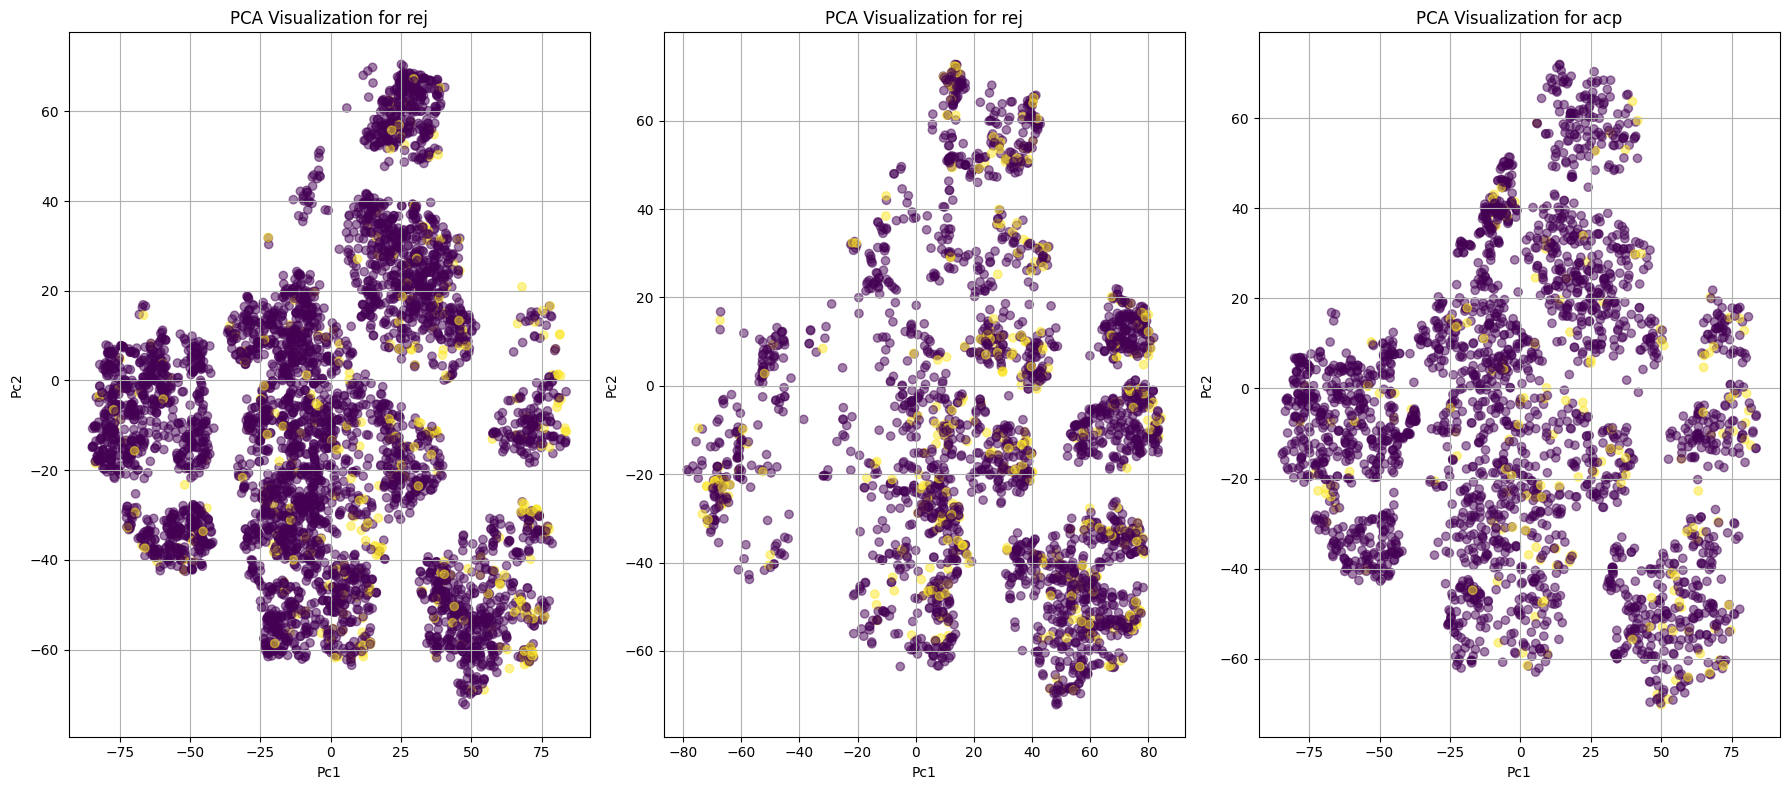

In [82]:

# Assuming finalDf is already defined and contains the relevant data
# Filter the DataFrame for gt == 0 and gt == 1
df_gt_0 = finalDf.loc[(finalDf['first_it'] >= 1), :]
df_gt_1 = finalDf.loc[(finalDf['first_it'] == -1), :]
df_gt_2 = finalDf.loc[(finalDf['first_it'] == 0), :]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

# Plot for gt == 0
scatter0 = axes[0].scatter(df_gt_0['Pc1'], df_gt_0['Pc2'], c=df_gt_0['gt'], cmap='viridis', alpha=0.5)
axes[0].set_title('PCA Visualization for rej')
axes[0].set_xlabel('Pc1')
axes[0].set_ylabel('Pc2')
axes[0].grid(True)
# axes[0].set_xlim(-8, 8)
# axes[0].set_ylim(-4, 10)
# cbar0 = plt.colorbar(scatter0, ax=axes[0])
# cbar0.set_label('Label')

# Plot for gt == 0
scatter1 = axes[1].scatter(df_gt_1['Pc1'], df_gt_1['Pc2'], c=df_gt_1['gt'], cmap='viridis', alpha=0.5)
axes[1].set_title('PCA Visualization for rej')
axes[1].set_xlabel('Pc1')
axes[1].set_ylabel('Pc2')
axes[1].grid(True)
# axes[1].set_xlim(-8, 8)
# axes[1].set_ylim(-4, 10)
# cbar1 = plt.colorbar(scatter1, ax=axes[1])
# cbar1.set_label('Label')


# Plot for gt == 1
scatter2 = axes[2].scatter(df_gt_2['Pc1'], df_gt_2['Pc2'], c=df_gt_2['gt'], cmap='viridis', alpha=0.5)
axes[2].set_title('PCA Visualization for acp')
axes[2].set_xlabel('Pc1')
axes[2].set_ylabel('Pc2')
axes[2].grid(True)
# axes[2].set_xlim(-8, 8)
# axes[2].set_ylim(-4, 10)
# cbar2 = plt.colorbar(scatter2, ax=axes[2])
# cbar2.set_label('Label')

# Adjust layout
plt.tight_layout()
plt.savefig('tsne-rej-out-acp.png')
plt.show()


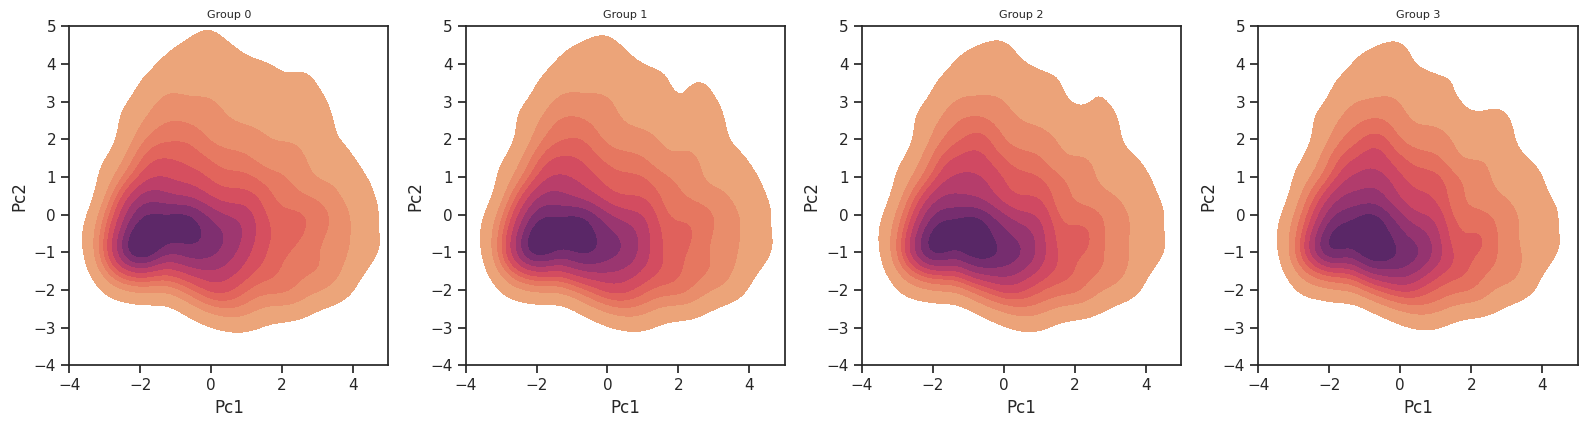

In [77]:
import math

# Define N as the total number of groups you want to plot
N = finalDf['first_it'].max()  # Number of unique first_its

# Calculate the number of rows and columns needed for the grid
n_cols = 5  # You can adjust this to your preference
n_rows = 2#math.ceil(N / n_cols)

sns.set_theme(style="ticks")
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))  # Adjust the figure size dynamically

# Flatten the axs array for easy iteration if there are multiple rows
axs = axs.flatten()

# For each first_it, create a KDE plot
for i in range(0, 5):  # Loop through the number of unique first_its
    ax = axs[i]
    sns.kdeplot(
        x="Pc1", y="Pc2", 
        data=finalDf.query(f"first_it <= {i} and label != 9999"),
        cmap="flare", fill=True, ax=ax
    )
    # sns.kdeplot(
    #     x="Pc1", y="Pc2", 
    #     data=finalDf.query(f"first_it <= {i} and label == 1"),
    #     cmap="Blues", fill=True, ax=ax
    # )
    ax.set_title(f'Group {i}', fontsize=8)
    ax.set_ylim([-4, 5])
    ax.set_xlim([-4, 5])

# Turn off the axes for any remaining empty subplots
for j in range(i, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.tight_layout()

plt.savefig(f'pca-{seed_number}-{size}-{p_value}-{contamination_threshold}.png')
plt.show()


In [19]:
ri.calculate_kickout_metric(hist_dict[0]['BM'], hist_dict[0]['A-SC'], X_val_acp, y_val_acp, X_val_rej)

(0.011793376610329817, 114, 8)

In [38]:
# main_seed = 9555
seed_number = main_seed

In [39]:
for fold_number in range(N_splits):
    print(seed_number+fold_number)

15444
15445
15446
15447
15448


In [15]:
# AR = 0.88
# metrics_dict = {}
# for fold_number in range(N_splits):
#     X_train_acp, X_train_rej, y_train_acp, y_train_rej, X_test_acp, X_test_rej, y_test_acp,X_val_acp, X_val_rej, y_val_acp = data_dict[fold_number]

#     seed_number = main_seed+fold_number
#     filepath = Path(os.path.join(ri_datasets_path,f'TN-{seed_number}.joblib'))
#     datasets = joblib.load(filepath)


#     values = ri.get_metrics_RI(datasets, X_val_acp, y_val_acp, X_unl = X_test_rej, threshold_type='none', 
#                             acp_rate=AR).loc[
#                                 ["Overall AUC", "Kickout"]].T.to_numpy()
#     weights = [1,10]
#     criterias = np.array([True, True])
#     t = top.Topsis(values, weights, criterias)
#     t.calc()
#     output = t.rank_to_best_similarity()[0] - 1
#     print(f'best iteration: {output}')
#     if output != 0:
#         hist_dict[fold_number]['TN'] = datasets[f'TN_{output}']
#     else:
#         hist_dict[fold_number]['TN'] = datasets['BM']
#     # break

In [ ]:
# hist_kick = []

# for i in range(1,97):
#     AR = i/100.
#     metrics_dict = {}
#     for fold_number in range(N_splits):
#         X_train_acp, X_train_rej, y_train_acp, y_train_rej, X_test_acp, X_test_rej, y_test_acp,X_val_acp, X_val_rej, y_val_acp = data_dict[fold_number]

#         seed_number = main_seed+fold_number
#         filepath = Path(os.path.join(ri_datasets_path,f'TN-{seed_number}.joblib'))
#         datasets = joblib.load(filepath)

#         values = []

#         for it in list(datasets.keys()):
#             auc_value = roc_auc_score(y_val_acp, datasets[it].predict_proba(X_val_acp)[:,1])
#             kick_value = ri.calculate_kickout_metric(datasets['BM'], datasets[it], X_val_acp, y_val_acp, X_val_rej, acp_rate=AR)
#             it_values = [auc_value, kick_value]
#             values.append(it_values)

#         values = ri.get_metrics_RI(datasets, X_val_acp, y_val_acp, X_unl = X_test_rej, threshold_type='none', 
#                                 acp_rate=AR).loc[
#                                     ["Overall AUC", "Kickout"]].T.to_numpy()
#         weights = [1,10]
#         criterias = np.array([True, True])
#         t = top.Topsis(values, weights, criterias)
#         t.calc()
#         output = t.rank_to_best_similarity()[0] - 1
#         # print(f'best iteration: {output}')
#         if output != 0:
#             hist_dict[fold_number]['TN'] = datasets[f'TN_{output}']
#         else:
#             hist_dict[fold_number]['TN'] = datasets['BM']

#         metrics_dict[fold_number] = ri.get_metrics_RI(hist_dict[fold_number], X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=AR)
#     # break
#     mean_metrics = sum([metrics_dict[i] for i in range(N_splits)])/N_splits
#     hist_kick.append(mean_metrics.loc[['Kickout']])
#     print(mean_metrics.loc[['Kickout']])

#     # break

In [44]:
hist_kick = []

for i in range(40,45):
    AR = i/100.
    metrics_dict = {}
    for fold_number in range(N_splits):
        X_train_acp, X_train_rej, y_train_acp, y_train_rej, X_test_acp, X_test_rej, y_test_acp,X_val_acp, X_val_rej, y_val_acp = data_dict[fold_number]

        seed_number = main_seed+fold_number
        filepath = Path(os.path.join(ri_datasets_path,f'TN-{seed_number}.joblib'))
        datasets = joblib.load(filepath)

        values = []

        for it in list(datasets.keys()):
            auc_value = roc_auc_score(y_val_acp, datasets[it].predict_proba(X_val_acp)[:,1])
            kick_value = ri.calculate_kickout_metric(datasets['BM'], datasets[it], X_val_acp, y_val_acp, X_val_rej, acp_rate=AR)[0]
            it_values = [auc_value, kick_value]
            values.append(it_values)

        values = np.array(values)
        weights = [1,10]
        criterias = np.array([True, True])
        t = top.Topsis(values, weights, criterias)
        t.calc()
        output = t.rank_to_best_similarity()[0] - 1
        # print(f'best iteration: {output}')
        if output != 0:
            hist_dict[fold_number]['TN'] = datasets[f'TN_{output}']
        else:
            hist_dict[fold_number]['TN'] = datasets['BM']

        metrics_dict[fold_number] = ri.get_metrics_RI(hist_dict[fold_number], X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej,
                                                    acp_rate=AR, threshold_type='none')
    # break
    mean_metrics = sum([metrics_dict[i] for i in range(N_splits)])/N_splits
    hist_kick.append(mean_metrics.loc[['Kickout']])
    print(mean_metrics.loc[['Kickout']])

    # break

          BM      A-SC        TN
Kickout  0.0  0.469514  0.483039
          BM     A-SC        TN
Kickout  0.0  0.44731  0.484416
          BM      A-SC        TN
Kickout  0.0  0.460041  0.451653
          BM      A-SC       TN
Kickout  0.0  0.483524  0.49267
          BM      A-SC        TN
Kickout  0.0  0.523575  0.527736


In [45]:
mean_metrics

,BM,A-SC,TN
Overall AUC,0.720724,0.713130,0.705341
KS,0.332525,0.323574,0.310177
Approval Rate,0.937877,0.924922,0.929903
Kickout,0.000000,0.523575,0.527736
KG,0.000000,435.400000,766.400000
KB,0.000000,20.200000,28.600000


In [46]:
df_kick = pd.concat(hist_kick, axis=0)

In [47]:
for column_name in df_kick.columns:
    column_data = df_kick[column_name]
    print(f"Column Name: {column_name}")
    print("Column Data:")
    print(column_data)
    print("--------------")

Column Name: BM
Column Data:
Kickout    0.0
Kickout    0.0
Kickout    0.0
Kickout    0.0
Kickout    0.0
Name: BM, dtype: float64
--------------
Column Name: A-SC
Column Data:
Kickout    0.469514
Kickout    0.447310
Kickout    0.460041
Kickout    0.483524
Kickout    0.523575
Name: A-SC, dtype: float64
--------------
Column Name: TN
Column Data:
Kickout    0.483039
Kickout    0.484416
Kickout    0.451653
Kickout    0.492670
Kickout    0.527736
Name: TN, dtype: float64
--------------


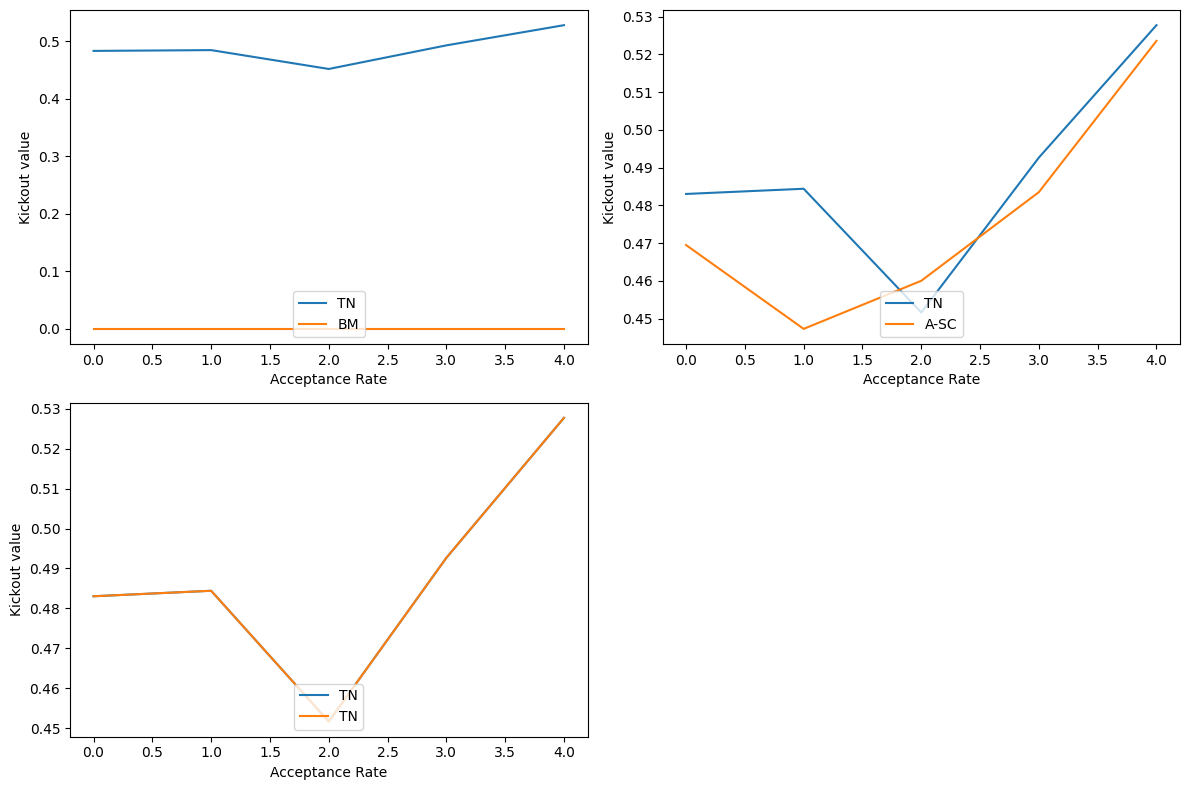

In [48]:
import math
import matplotlib.pyplot as plt

num_plots = len(df_kick.columns)
num_cols = math.ceil(math.sqrt(num_plots))
num_rows = math.ceil(num_plots / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, column_name in enumerate(df_kick.columns):
    column_data = df_kick[column_name]
    row = i // num_cols
    col = i % num_cols

    axs[row, col].plot(df_kick['TN'].values, label='TN')
    axs[row, col].plot(column_data.values, label=column_name)
    axs[row, col].set_xlabel('Acceptance Rate')
    axs[row, col].set_ylabel('Kickout value')
    axs[row, col].legend(loc='lower center')

# Hide unused subplots
for i in range(num_plots, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    if num_rows == 1 and num_cols == 1:
        axs.axis('off')
    else:
        axs[row, col].axis('off')

plt.tight_layout()
plt.savefig(f'all_kick_by_AR_{main_seed}',  dpi=150)
plt.show()


ValueError: x and y can be no greater than 2D, but have shapes (96,) and (96, 1, 9)

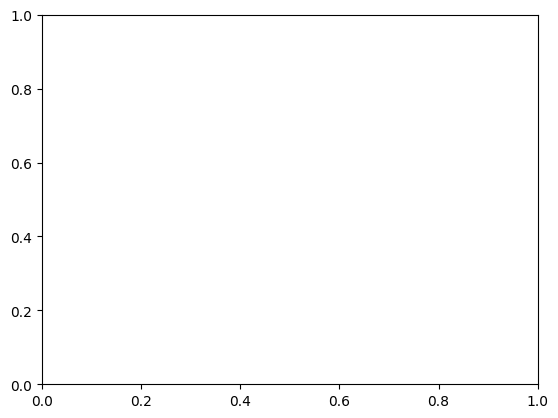

In [25]:
plt.plot(hist_kick)
plt.show()
# plt.savefig('kick_by_AR',  dpi=150)

In [24]:
# filepath = Path(os.path.join(ri_datasets_path,f'kickout-{main_seed}-ALL.joblib'))
# filepath.parent.mkdir(parents=True, exist_ok=True)
# joblib.dump(df_kick, filepath)

['../data/riData/kickout-5444-ALL.joblib']

In [ ]:
# mean_metrics = ri.get_metrics_RI(hist_dict[0], X_test_acp, 
#                                  y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=0.5)

In [ ]:
metrics_dict = {}
for fold_number in range(N_splits):
    X_train_acp, X_train_rej, y_train_acp, y_train_rej,X_test_acp, X_test_rej, y_test_acp,X_val_acp, X_val_rej, y_val_acp = data_dict[fold_number]

    metrics_dict[fold_number] = ri.get_metrics_RI(hist_dict[fold_number], X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=AR)
    # break
mean_metrics = sum([metrics_dict[i] for i in range(N_splits)])/N_splits
mean_metrics

    

,BM,A-SC,A-UW,A-DW,A-FU,E-C,PAR,LSP,TN
Overall AUC,0.723714,0.715438,0.720859,0.721782,0.691669,0.719875,0.717728,0.714254,0.707379
KS,0.332597,0.328778,0.332262,0.338015,0.289333,0.330676,0.324048,0.324543,0.308939
Balanced Accuracy,0.661032,0.661106,0.661436,0.661722,0.636495,0.656293,0.656869,0.653754,0.648553
Accuracy,0.702372,0.666749,0.641306,0.678005,0.663588,0.631125,0.664581,0.663273,0.635757
Precision,0.097385,0.091668,0.088799,0.094706,0.086454,0.087113,0.090580,0.089588,0.084562
Recall,0.615265,0.654826,0.683662,0.643566,0.606416,0.684054,0.648277,0.643232,0.662739
F1,0.167819,0.160636,0.156823,0.164165,0.150618,0.153912,0.158462,0.156822,0.149947
Approval Rate,0.937560,0.927719,0.931973,0.936380,0.914149,0.939397,0.937021,0.932209,0.923497
Kickout,0.000000,0.595869,0.299758,0.480291,0.207402,0.295369,0.390701,0.562368,0.639263
KG,0.000000,394.400000,108.600000,162.000000,229.200000,75.600000,82.000000,258.400000,553.400000


In [ ]:
metric = mean_metrics.loc[['Overall AUC', 'Kickout', 'Approval Rate'], 'TN']

In [ ]:
metric

Overall AUC      0.707379
Kickout          0.639263
Approval Rate    0.923497
Name: TN, dtype: float64

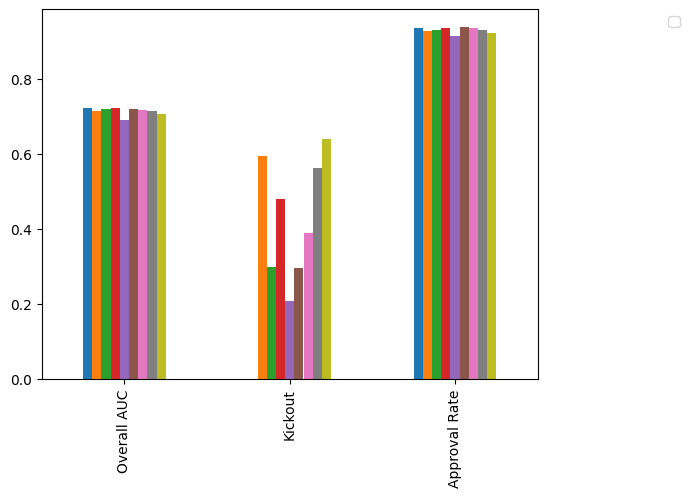

In [ ]:
metric.plot.bar().legend([], loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))
plt.show()

In [ ]:
# AR = 0.8

In [ ]:
metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=AR)

In [ ]:
cols = ['Overall AUC','Kickout',]

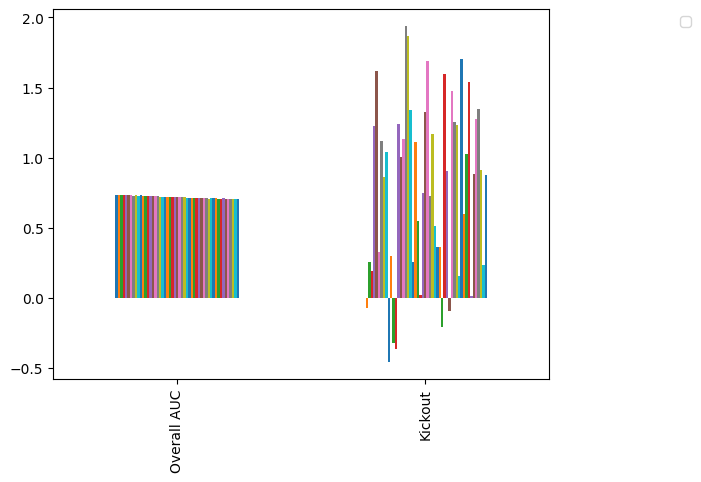

In [ ]:
metrics.loc[cols].plot.bar().legend([], loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

In [ ]:
metrics

,BM,TN_1,TN_2,TN_3,TN_4,TN_5,TN_6,TN_7,TN_8,TN_9,...,TN_41,TN_42,TN_43,TN_44,TN_45,TN_46,TN_47,TN_48,TN_49,TN_50
Overall AUC,0.733256,0.734027,0.734435,0.735068,0.734668,0.734612,0.732012,0.730095,0.731365,0.730129,...,0.709029,0.708862,0.708267,0.708985,0.706606,0.706427,0.706937,0.707295,0.707632,0.705952
KS,0.352863,0.355920,0.350561,0.355742,0.365893,0.359213,0.357499,0.355781,0.355432,0.356794,...,0.314461,0.311651,0.309941,0.315502,0.305765,0.310062,0.307019,0.311385,0.320709,0.308299
Balanced Accuracy,0.674276,0.673098,0.668296,0.668849,0.672535,0.674106,0.674892,0.671259,0.674128,0.670338,...,0.649642,0.655215,0.651630,0.649908,0.647900,0.651324,0.648701,0.651631,0.654676,0.649261
Accuracy,0.670786,0.662310,0.717955,0.606859,0.640052,0.636817,0.652022,0.611453,0.653057,0.629634,...,0.679909,0.665610,0.637593,0.666710,0.649175,0.641993,0.671886,0.632611,0.649628,0.636817
Precision,0.092201,0.090743,0.098585,0.083476,0.087794,0.087749,0.089787,0.084409,0.089750,0.086135,...,0.087568,0.087037,0.082991,0.085923,0.083407,0.083391,0.086286,0.082476,0.084986,0.082393
Recall,0.678129,0.685007,0.613480,0.737276,0.708391,0.715268,0.700138,0.737276,0.697387,0.715268,...,0.616231,0.643741,0.667125,0.631362,0.646492,0.661623,0.623109,0.672627,0.660248,0.662999
F1,0.162331,0.160257,0.169872,0.149972,0.156226,0.156320,0.159162,0.151477,0.159034,0.153755,...,0.153346,0.153342,0.147618,0.151261,0.147752,0.148114,0.151581,0.146935,0.150588,0.146571
Approval Rate,0.950696,0.949984,0.947525,0.950954,0.944937,0.945066,0.947137,0.945455,0.946684,0.945843,...,0.926432,0.926302,0.923714,0.926626,0.924685,0.926561,0.922096,0.928243,0.927661,0.929149
Kickout,0.000000,-0.070845,0.254768,0.194823,1.226158,1.617166,0.328338,1.121253,0.859673,1.043597,...,0.596730,1.025886,1.542234,0.014986,0.884196,1.275204,1.346049,0.911444,0.231608,0.873297
KG,0.000000,13.000000,45.000000,56.000000,142.000000,162.000000,215.000000,253.000000,301.000000,359.000000,...,808.000000,821.000000,818.000000,823.000000,847.000000,867.000000,854.000000,842.000000,875.000000,849.000000


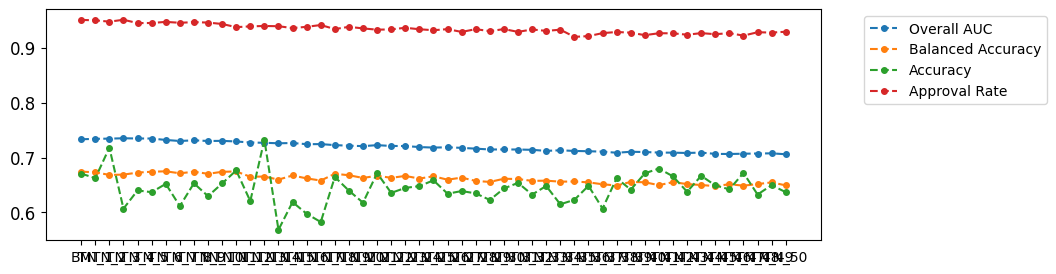

In [ ]:
#@title Show evolution of metrics

metrics_df = metrics.copy()#_techniques.copy()

# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot =  ['Overall AUC', 'Balanced Accuracy', 'Accuracy', 'Approval Rate']
cols_plotted = []

# Iterate over the columns of metrics_df.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()

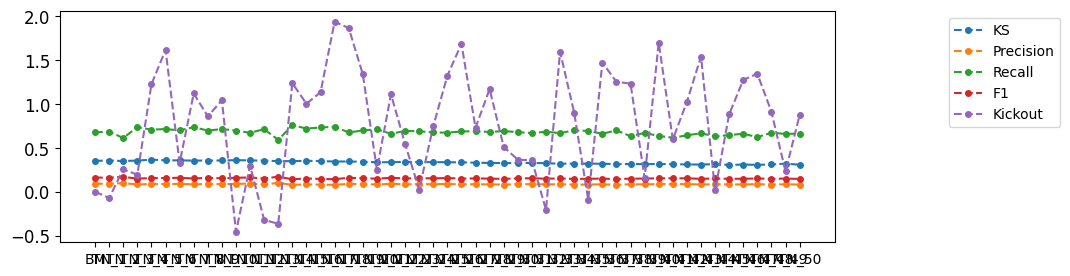

In [ ]:
#@title Show evolution of metrics
# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot = ['KS','Precision', 'Recall','F1', 'Kickout']
cols_plotted = []

# Iterate over the columns of metrics.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()